## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [2]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [3]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [4]:
#label for 0 is 10, let's change that

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

## Extract a random validation set from the training set
In this case the size of the validation set is 7% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [5]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 3), (7325, 32, 32, 3), (65932, 1), (7325, 1))

## Visualize the images

In [19]:
#Function to visualize image with their respective labels
def plot_img(images, labels, images_number=4):
    plt.figure(figsize=(8,8))
    for i in range(images_number**2):
        plt.subplot(images_number, images_number, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,:], cmap=plt.cm.binary)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

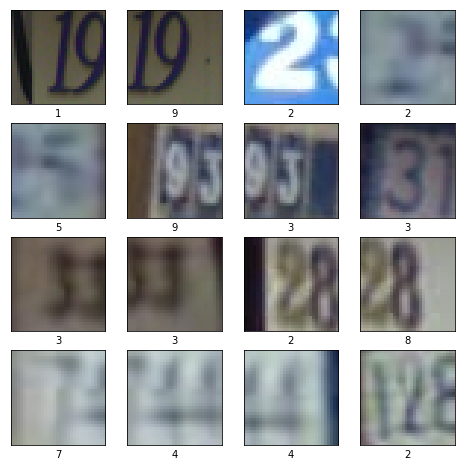

In [11]:
#Check if the training set is divided correctely and print the data
plot_img(train_img, train_lbs)

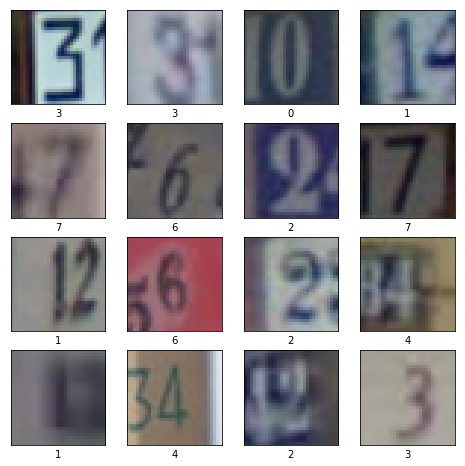

In [7]:
#Check if the validation set is divided correctely and print the data
plot_img(validation_img, validation_lbs)

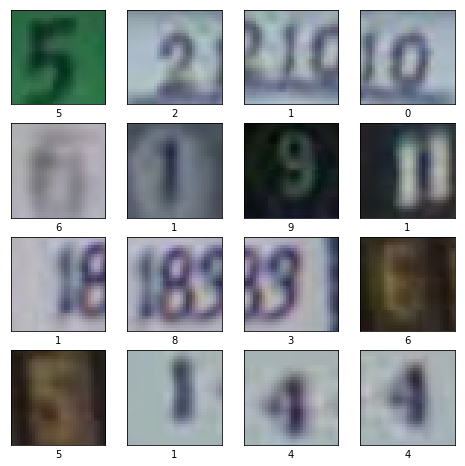

In [8]:
#Check if the test set is divided correctely and print the data
plot_img(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [6]:
#cast to float otherwise during mean subtraction floats would be casted to ints
train_img = train_img.astype(float)

#zero center across each colour channel
rmean = np.mean(train_img[:,:,:,0])
bmean = np.mean(train_img[:,:,:,1])
gmean = np.mean(train_img[:,:,:,2])

train_img[:,:,:,0] = train_img[:,:,:,0]-rmean
train_img[:,:,:,1] = train_img[:,:,:,1]-bmean
train_img[:,:,:,2] = train_img[:,:,:,2]-gmean


#normalize by dividing each dimension colour channel by its standard deviation
rstd = np.std(train_img[:,:,:,0])
bstd = np.std(train_img[:,:,:,1])
gstd = np.std(train_img[:,:,:,2])

train_img[:,:,:,0] = train_img[:,:,:,0]/rstd
train_img[:,:,:,1] = train_img[:,:,:,1]/bstd
train_img[:,:,:,2] = train_img[:,:,:,2]/gstd

In [7]:
#do the same on the validation set and training set
test_img = test_img.astype(float)
validation_img = validation_img.astype(float)

test_img[:,:,:,0] = test_img[:,:,:,0]-rmean
test_img[:,:,:,1] = test_img[:,:,:,1]-bmean
test_img[:,:,:,2] = test_img[:,:,:,2]-gmean

test_img[:,:,:,0] = test_img[:,:,:,0]/rstd
test_img[:,:,:,1] = test_img[:,:,:,1]/bstd
test_img[:,:,:,2] = test_img[:,:,:,2]/gstd

validation_img[:,:,:,0] = validation_img[:,:,:,0]-rmean
validation_img[:,:,:,1] = validation_img[:,:,:,1]-bmean
validation_img[:,:,:,2] = validation_img[:,:,:,2]-gmean

validation_img[:,:,:,0] = validation_img[:,:,:,0]/rstd
validation_img[:,:,:,1] = validation_img[:,:,:,1]/bstd
validation_img[:,:,:,2] = validation_img[:,:,:,2]/gstd


## Hyper-parameters Optimization

In [19]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

Here are defined a few things that will be usefull during the training:
 - the number of epochs the training algorithm will run
 - a function that allows to save the trained model in a file every three epochs (usefull if you don't want to run the training again)
 - a function that defines the decay of the learning rate
 - a function that plots validation statistics

In [50]:
#train on 10 epochs
epoch_num = 6

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#learning rate decay call back    
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [9]:
#define function to plot accuracy or loss
def plot_validation(number_of_models, history, loss=False):
    name, key, loc, f = 'Accuracy', 'acc', 'upper left', max
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(val_errors[i].history['val_'+key], label='val_'+key+str(i))
        print("CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}".format(
            i,epoch_num,name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    if loss: plt.ylim([0., 0.6])
    else: plt.ylim([0.8, 1])
    plt.legend(loc='upper left')
    plt.show()

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

In [72]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    if i > 0:
        model.add(layers.Conv2D(24, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.Conv2D(24, (3,3), activation='relu'))
        model.add(layers.Conv2D(24, (3,3), strides=2, activation='relu'))
        model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))
    else:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(144, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [73]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/structure/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 57s 871us/sample - loss: 0.7803 - acc: 0.7623 - val_loss: 0.5200 - val_acc: 0.8528
Epoch 2/6
65932/65932 [==============================] - 57s 868us/sample - loss: 0.4305 - acc: 0.8739 - val_loss: 0.4087 - val_acc: 0.8788
Epoch 3/6
65932/65932 [==============================] - 61s 928us/sample - loss: 0.3461 - acc: 0.8983 - val_loss: 0.3940 - val_acc: 0.8870
Epoch 4/6
65932/65932 [==============================] - 57s 860us/sample - loss: 0.2916 - acc: 0.9143 - val_loss: 0.3975 - val_acc: 0.8853
Epoch 5/6
65932/65932 [==============================] - 57s 866us/sample - loss: 0.2494 - acc: 0.9272 - val_loss: 0.4002 - val_acc: 0.8886
Epoch 6/6
65932/65932 [==============================] - 58s 877us/sample - loss: 0.2162 - acc: 0.9363 - val_loss: 0.4075 - val_acc: 0.8889
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 57s 8

CNN 0: Epochs=6, Train Accuracy=0.93628, Validation Accuracy=0.88887
CNN 1: Epochs=6, Train Accuracy=0.95635, Validation Accuracy=0.91945


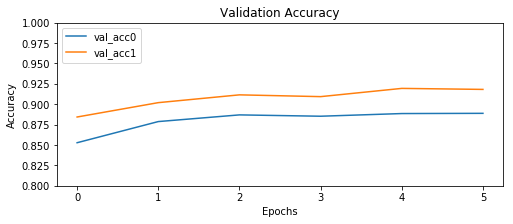

CNN 0: Epochs=6, Train Loss=0.21616, Validation Loss=0.39402
CNN 1: Epochs=6, Train Loss=0.14763, Validation Loss=0.28484


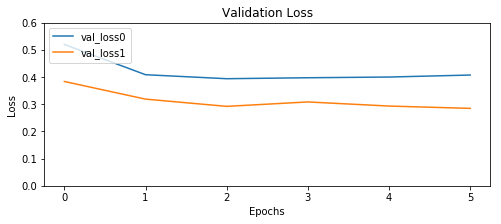

In [77]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The second model (without max pooling) performs better.

### Validate the number of covolutional layers

In [79]:
#val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(24, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    if i > 0:
        model.add(layers.Conv2D(24, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(24, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(24, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [80]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 24s 359us/sample - loss: 0.7712 - acc: 0.7543 - val_loss: 0.4720 - val_acc: 0.8583
Epoch 2/6
65932/65932 [==============================] - 22s 341us/sample - loss: 0.3868 - acc: 0.8846 - val_loss: 0.3800 - val_acc: 0.8855
Epoch 3/6
65932/65932 [==============================] - 30s 450us/sample - loss: 0.3065 - acc: 0.9078 - val_loss: 0.3641 - val_acc: 0.8942
Epoch 4/6
65932/65932 [==============================] - 25s 375us/sample - loss: 0.2517 - acc: 0.9250 - val_loss: 0.3231 - val_acc: 0.9031
Epoch 5/6
65932/65932 [==============================] - 25s 375us/sample - loss: 0.2082 - acc: 0.9383 - val_loss: 0.3365 - val_acc: 0.9095
Epoch 6/6
65932/65932 [==============================] - 25s 378us/sample - loss: 0.1725 - acc: 0.9495 - val_loss: 0.3518 - val_acc: 0.9059
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 69s 1

CNN 0: Epochs=6, Train Accuracy=0.94948, Validation Accuracy=0.90949
CNN 1: Epochs=6, Train Accuracy=0.95134, Validation Accuracy=0.91645
CNN 2: Epochs=6, Train Accuracy=0.95894, Validation Accuracy=0.91563
CNN 3: Epochs=6, Train Accuracy=0.96061, Validation Accuracy=0.91645
CNN 4: Epochs=6, Train Accuracy=0.94563, Validation Accuracy=0.91495
CNN 5: Epochs=6, Train Accuracy=0.95671, Validation Accuracy=0.91263


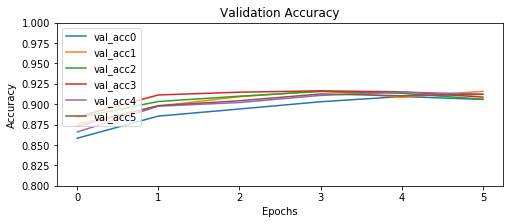

CNN 0: Epochs=6, Train Loss=0.17246, Validation Loss=0.32315
CNN 1: Epochs=6, Train Loss=0.16570, Validation Loss=0.29122
CNN 2: Epochs=6, Train Loss=0.13806, Validation Loss=0.31058
CNN 3: Epochs=6, Train Loss=0.13060, Validation Loss=0.28852
CNN 4: Epochs=6, Train Loss=0.18844, Validation Loss=0.28617
CNN 5: Epochs=6, Train Loss=0.14536, Validation Loss=0.31786


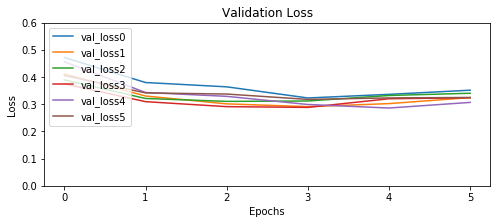

In [81]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The  fourth and fifth model perform almost equally, but the fifth has less parameters, therefore it will be chosen.

In [82]:
val_models[3].summary()
val_models[4].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_294 (Conv2D)          (None, 32, 32, 24)        672       
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 32, 32, 24)        5208      
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 15, 15, 24)        5208      
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 15, 15, 48)        10416     
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 15, 15, 48)        20784     
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 7, 7, 16)          6928      
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 7, 7, 64)          9280      
__________

### Validate the number of filters per layer

In [83]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [59]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/filters/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 122s 2ms/sample - loss: 0.7011 - acc: 0.7748 - val_loss: 0.3637 - val_acc: 0.8927
Epoch 2/6
65932/65932 [==============================] - 118s 2ms/sample - loss: 0.3054 - acc: 0.9094 - val_loss: 0.3063 - val_acc: 0.9099
Epoch 3/6
65932/65932 [==============================] - 119s 2ms/sample - loss: 0.2385 - acc: 0.9305 - val_loss: 0.3007 - val_acc: 0.9100
Epoch 4/6
65932/65932 [==============================] - 116s 2ms/sample - loss: 0.1874 - acc: 0.9450 - val_loss: 0.2972 - val_acc: 0.9180
Epoch 5/6
65932/65932 [==============================] - 118s 2ms/sample - loss: 0.1435 - acc: 0.9581 - val_loss: 0.3272 - val_acc: 0.9126
Epoch 6/6
65932/65932 [==============================] - 118s 2ms/sample - loss: 0.1106 - acc: 0.9664 - val_loss: 0.3283 - val_acc: 0.9152


CNN 0: Epochs=6, Train Accuracy=0.96642, Validation Accuracy=0.91795


IndexError: list index out of range

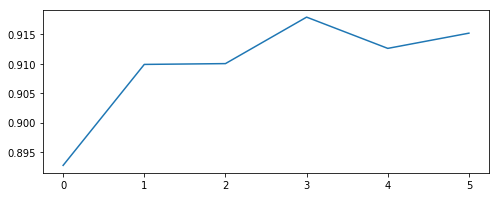

In [60]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The thrid model, with 24 and 48 filters exhibits good performance with less parameters.

In [ ]:
val_models[2].summary()

### Validate the neurons in the fully connected layer

### Validate droput